In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [21]:
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import  files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import read_saved_epochs, Data_Splitter
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from pc_completions.evaluation import basic_comletion_measures

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
n_pc_points = 2048
do_training = True
first_time_running = True
load_model = False
load_epoch = None
seed = 42
top_data_dir = '/orions4-zfs/projects/optas/DATA'
train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_10_2048pts_emd')

In [13]:
# Load complete Point-Clouds of single class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = [f for f in files_in_subdirs(pclouds_path, '.ply')]
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(file_names=file_names, n_threads=50, loader=snc_loader)
assert(len(np.unique(syn_ids)) == 1)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds, labels=model_ids)

6778 files containing complete point clouds were found.


In [18]:
conf = Conf.load(osp.join(train_dir, 'configuration'))
print conf
if conf.train_dir != train_dir:
    conf.train_dir = train_dir
conf.save(osp.join(train_dir, 'configuration'))

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'layer_sizes': [1024, 2048, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'filter_sizes': [40, 20, 10, 10], 'n_filters': [128, 128, 256, 32], 'strides': [1, 2, 2, 1]}
               experiment_name: ae_farm_chair_conv_arch_10_2048pts_emd
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models

In [22]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
if load_epoch is None: # load last saved.
    saved_epochs = read_saved_epochs(conf.train_dir)
    load_epoch = saved_epochs[-1]        
ae.restore_model(conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [54]:
# Check signum of gradient.

In [348]:
pclouds_to_check = train_data.point_clouds[0:10]

In [349]:
new_shape = [ae.bottleneck_size] + list(pclouds_to_check.shape)
grad_signal = np.zeros(shape=new_shape)

for dim in range(ae.bottleneck_size):
    grad_signal[dim] = ae.gradient_of_input_wrt_latent_code(pclouds_to_check, [dim])

In [350]:
abs_sum_grad = np.sum(abs(grad_signal), -1)

In [351]:
indicators = abs_sum_grad.transpose([1, 2, 0]) > 0

In [352]:
indicators[0, :, k]

array([False, False, False, ..., False, False, False], dtype=bool)

113 0


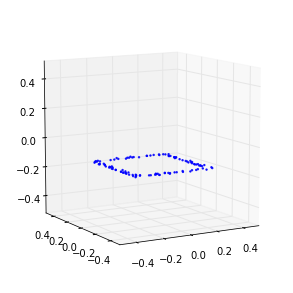

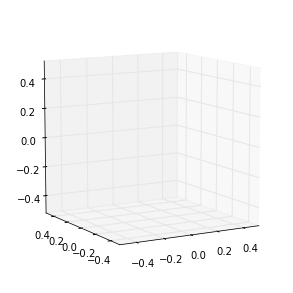

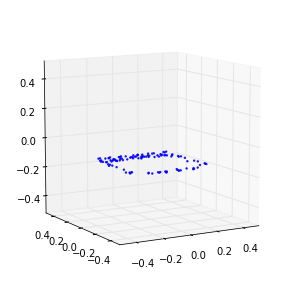

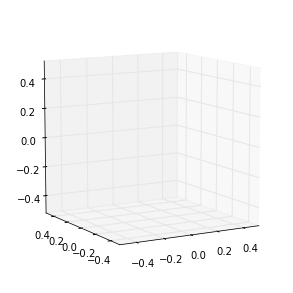

In [359]:
k = 6

print np.sum(indicators[0, :, k]), np.sum(indicators[1, :, k])

Point_Cloud(pclouds_to_check[0][indicators[0, :, k], :]).plot();
Point_Cloud(pclouds_to_check[1][indicators[1, :, k], :]).plot();
Point_Cloud(pclouds_to_check[0][indicators[2, :, k], :]).plot();
Point_Cloud(pclouds_to_check[1][indicators[3, :, k], :]).plot();


In [360]:
unique_activation_patterns = dict()
counter = 1
for i in range(len(indicators)):
    for row in indicators[i]:
        if not tuple(row) in unique_activation_patterns:
            unique_activation_patterns[tuple(row)] = counter
            counter += 1

print 'Unique-patterns = ', len(unique_activation_patterns)

Unique-patterns =  113


In [361]:
color = np.zeros(indicators.shape[:-1])
for i in range(len(indicators)):
    for j, row in enumerate(indicators[i]):
        color[i,j] = unique_activation_patterns[tuple(row)]

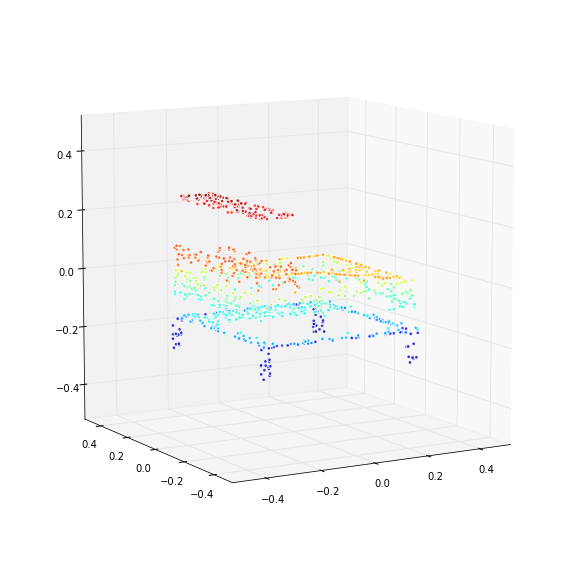

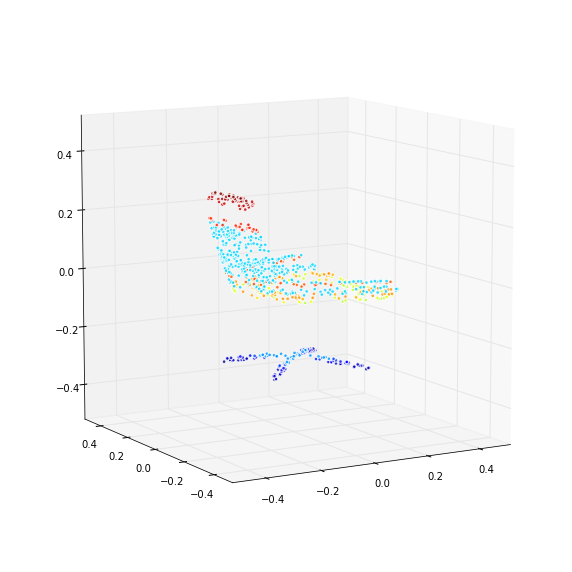

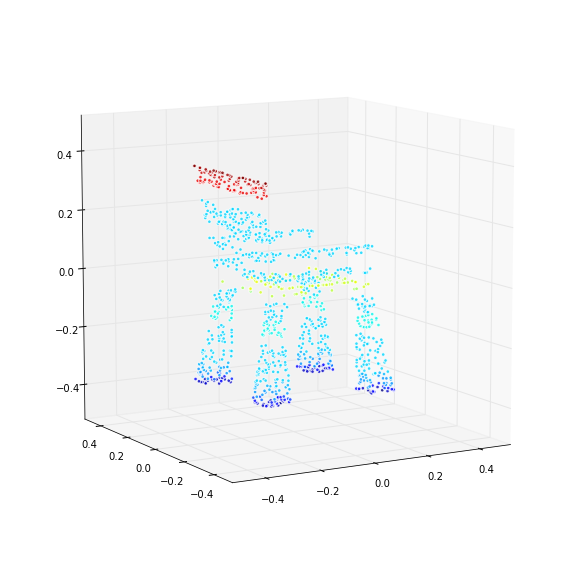

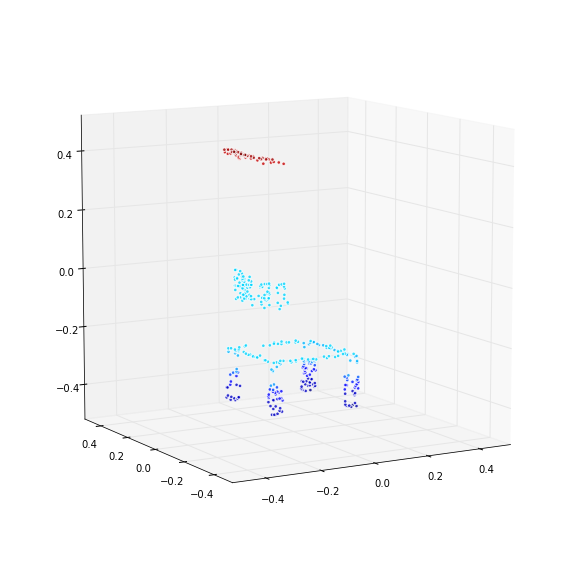

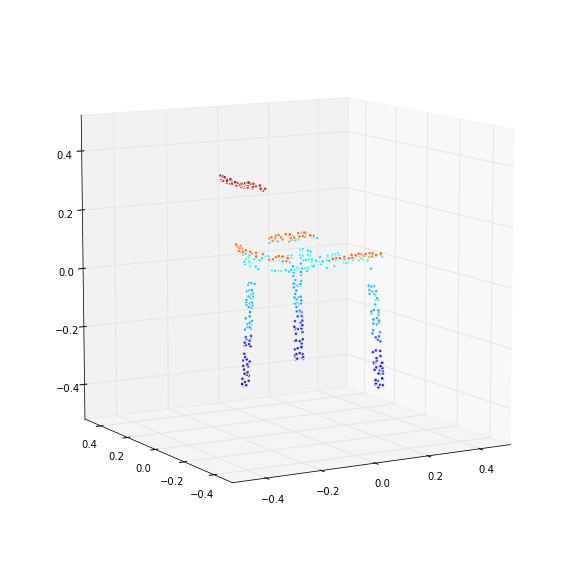

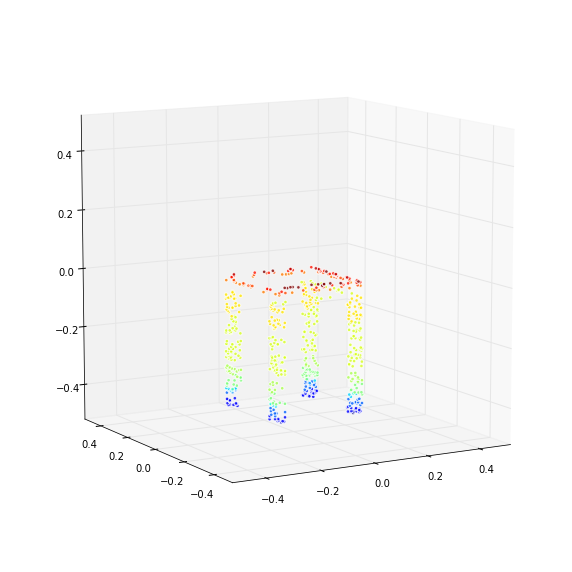

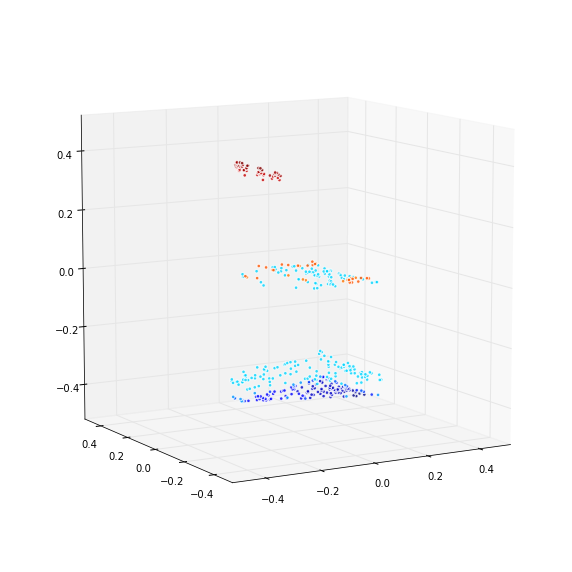

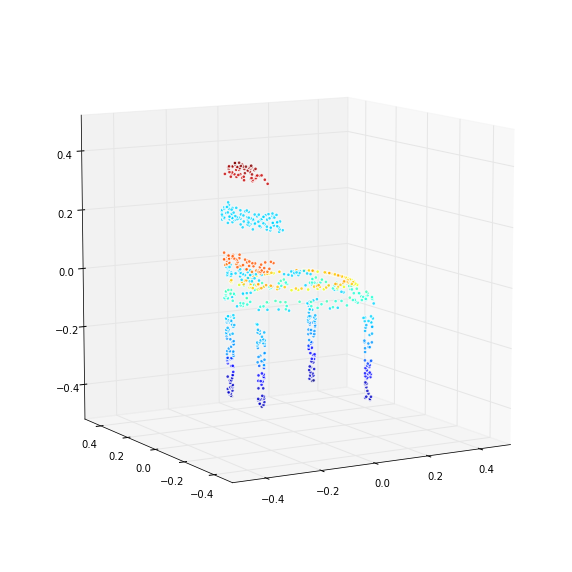

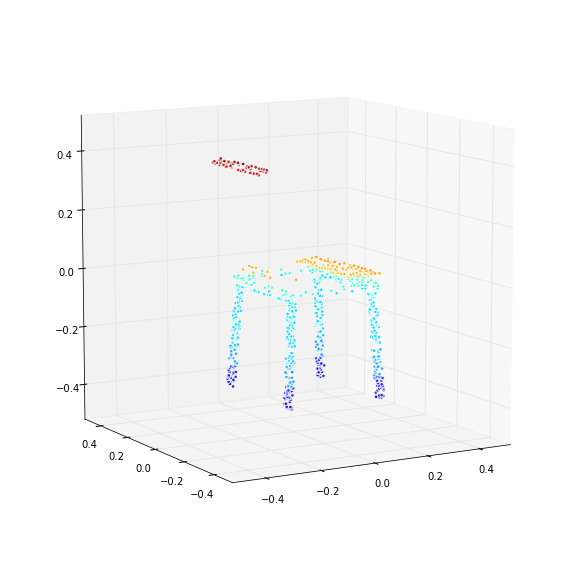

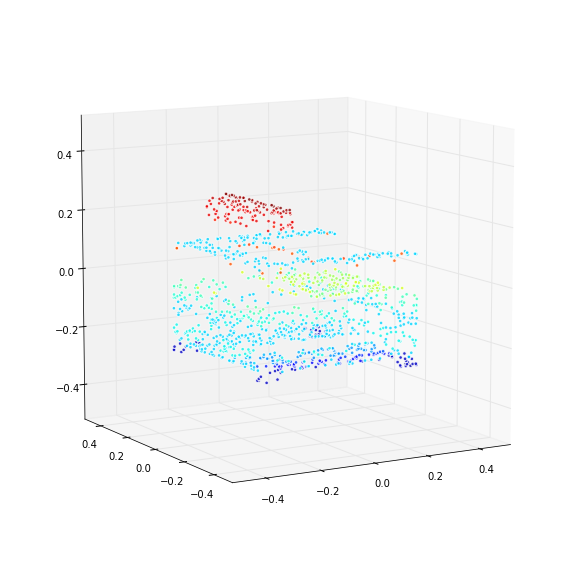

In [366]:
for i in range(len(pclouds_to_check)):
    non_zero = [np.any(indicators[i ,:, :], axis=1)]
    Point_Cloud(pclouds_to_check[i][non_zero]).plot(c=color[0][non_zero], s=50, color='w', figsize=(10,10));

In [ ]:
from sklearn.cluster import KMeans